In [1]:
import pandas as pd

In [2]:
doc_pd = pd.read_csv('../all.csv',sep="|")

In [3]:
doc_pd['rev1'][0]

'These are the perfect tights for my 5-year old. The tights are very well made and have already lasted several washings (hang dry). The color is beautiful, and my daughter loves that she can wear flip-flops to class like the big girls do.'

In [4]:
import re

def first_process(text):
    text = re.sub(r'[^\w\s\.]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)                                 # delete URL
    text = re.sub(r'  ',' ', text)                                                    # delete more space
    text = re.sub(r'([!()\-{};:,<>./?@#$%\^&*_~])\1+', lambda x: x.group()[0], text)  # delete more punc
    text = re.sub(r'[^\x00-\x7F]+',' ', text)                                         # replace non-ASCII with a space
    text = text.lower()
    text = text.strip()
    return text

In [5]:
column_rev = ['rev1','rev2','rev3','rev4','rev5','rev6','rev7','rev8']

In [6]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>


False

In [11]:
data = []
for i in range(len(doc_pd)):
  contain_cl = []
  for cl in column_rev:
    fp = first_process(doc_pd[cl][i])
    contain_cl.extend(sent_tokenize(fp))
  data.append(contain_cl)

In [12]:
column_abs = ['summ1','summ2','summ3']

In [14]:
doc_abs = []
doc_abs_one = []
for i in range(len(doc_pd)):
  contain_cl = []
  for cl in column_abs:
    sentcon = sent_tokenize(doc_pd[cl][i])
    sentcon = '\n'.join(sentcon)
    contain_cl.append(sentcon)

  doc_abs.append(contain_cl)
  doc_abs_one.append(doc_pd['summ1'][i])

In [15]:
doc_abs[0]

['These tights are great.\nThey are durable and do not tear easily, they can be worn and washed without worry.\nThe bottoms of can be pulled up easily so that sandals can be worn with them.\nIt might be a good idea to order a size bigger because they can be a little tight in the waist.\nOverall, these tights are definitely recommended.',
 'These transition tights are perfect for children sensitive to the tight sensation other tights have around the foot.\nThe material is soft and durable; they stand up well to both the rough nature of children, and the washing machine.\nThis product does tend to run slightly small, so purchasing one size up is recommended.',
 'Bought these for my 3 year old daughter for her classes and they turned out great and fit perfectly.\nShe can pull them up to walk in then pull down to cover her toes for class.\nStrong tights that should last.\nYou might need to buy a size up just for comfort around the waist.']

In [41]:
from nltk.tokenize import word_tokenize, sent_tokenize

djumlahKata = []
djumlahKalimat = []
for dt in data:
    for dtt in dt:
        tmp_dt = []
        for kata in dtt:
            tmp_dt.extend(kata.split(' '))
        djumlahKalimat.append(len(dtt))    
    djumlahKata.append(len(tmp_dt))

rjumlahKata = []
rjumlahKalimat = []
for dt_ringkasan in doc_abs:
    for index_dtr in dt_ringkasan:
        rjumlahKata.append(len(index_dtr.split(' ')))
        rjumlahKalimat.append(len(index_dtr.split('\n')))

In [42]:
import numpy as np
print(np.mean(rjumlahKalimat)), print(np.mean(rjumlahKata))

3.9555555555555557
53.0


(None, None)

In [71]:
print(np.mean(rjumlahKalimat)), print(np.mean(rjumlahKata))

6.088888888888889
244.86666666666667


(None, None)

In [16]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# Load pre-trained model tokenizer (vocabulary-multilingual)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)

The pre-trained model you are loading is an uncased model but you have set `do_lower_case` to False. We are setting `do_lower_case=True` for you but you may want to check this behavior.


In [17]:
def sentence_emb(text, model):
  marked_text = "[CLS] " + text + " [SEP]"

  # Tokenize our sentence with the BERT tokenizer.
  tokenized_text = tokenizer.tokenize(marked_text)
  segments_ids = [1] * len(tokenized_text)

  # Map the token strings to their vocabulary indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

  # Convert inputs to PyTorch tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  # Put the model in "evaluation" mode, meaning feed-forward operation.
  model.eval()

  # Predict hidden states features for each layer
  with torch.no_grad():
      encoded_layers, _ = model(tokens_tensor, segments_tensors)

  # Concatenate the tensors for all layers. We use `stack` here to
  # create a new dimension in the tensor.
  token_embeddings = torch.stack(encoded_layers, dim=0)

  # Remove dimension 1, the "batches".
  token_embeddings = torch.squeeze(token_embeddings, dim=1)

  # Swap dimensions 0 and 1.
  token_embeddings = token_embeddings.permute(1,0,2)

  token_embeddings.size()

  # `encoded_layers` has shape [12 x 1 x 23 x 768]

  # `token_vecs` is a tensor with shape [23 x 768]
  token_vecs = encoded_layers[11][0]

  # Calculate the average of all 23 token vectors.
  sentence_embedding = torch.mean(token_vecs, dim=0)

  return sentence_embedding

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
import string
exclude = set(string.punctuation)

def cleaning(data, stem=False, stopword=False):
  cleaned_data = []
  if stem == False and stopword== False:
    for yy in data:
        filtered_sentence = []
        word_tokens = yy.split()
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        cleaned_data.append(' '.join(filtered_sentence))
  else:
    for yy in data:
        filtered_sentence = []
        yy = ''.join(ch for ch in yy if ch not in exclude)
        word_tokens = yy.split()
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        cleaned_data.append(' '.join(filtered_sentence))

  return cleaned_data

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>


In [19]:
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.cluster import DBSCAN

In [20]:
from sklearn.metrics import silhouette_score

def get_silhouette (model_c, embedding, k_max):
  silhouette = {}

  for k in range(2, k_max):
    if model_c =='Agglomerative':
      model = AgglomerativeClustering(n_clusters=k).fit(embedding)
    elif model_c =='KMeans':
      model = KMeans(n_clusters=k, n_init=10).fit(embedding)
    else:
      model = KMedoids(n_clusters=k, init='k-medoids++').fit(embedding)
    silhouette[k] = silhouette_score(embedding, model.labels_)

  max_value = max(silhouette.values())
  max_index = max(silhouette, key=silhouette.get)

  return max_index, max_value

In [21]:
from sklearn.metrics import davies_bouldin_score

def dbi (model_c, embedding, k_max):
  if model_c == 'Agglomerative':
    model = AgglomerativeClustering(k_max).fit(embedding)
  elif model_c =='KMeans':
    model = KMeans(k_max, n_init=10).fit(embedding)
  else:
    model = KMedoids(k_max, init='k-medoids++').fit(embedding)

  dbi = davies_bouldin_score(embedding, model.labels_)

  return dbi

In [22]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

def elbow(model_c, embedding, k_max):
  if model_c=='Agglomerative':
    elb_visualizer = KElbowVisualizer(AgglomerativeClustering(), k=(2,k_max), timings=False).fit(embedding)
  elif model_c=='KMeans':
    elb_visualizer = KElbowVisualizer(KMeans(n_init=10), k=(2,k_max), timings=False).fit(embedding)
  else:
    elb_visualizer = KElbowVisualizer(KMedoids(init='k-medoids++'), k=(2,k_max), timings=False).fit(embedding)

  max_index = elb_visualizer.elbow_value_
  max_value = elb_visualizer.elbow_score_

  return max_index, max_value

In [23]:
from sklearn.metrics import calinski_harabasz_score

def chi(model, embedding, k_max):
  if model=='Agglomerative':
    model = AgglomerativeClustering(k_max).fit(embedding)
  elif model=='KMeans':
    model = KMeans(n_clusters=k_max, n_init=10).fit(embedding)
  else:
    model = KMedoids(k_max, init='k-medoids++').fit(embedding)

  chi = calinski_harabasz_score(embedding, model.labels_)

  return chi

In [109]:
def n_clustering(model_c, embeddingr, k_max):
    pca = PCA(n_components=2)
    embedding = pca.fit_transform(embeddingr)
    clus = []

    ss, score_s = get_silhouette(model_c, embedding, k_max)
    el, score_e = elbow(model_c, embedding, k_max)

    clus = [ss, el]

    for cl in clus:
        if cl is None:
            clus.remove(cl)

    print(clus)
    clus.sort(reverse=True)
    clus_opt = {x:clus.count(x) for x in clus}
    index_max = max(clus_opt, key=clus_opt.get)

    score_chi = chi(model_c, embedding, index_max)
    score_dbi = dbi(model_c, embedding, index_max)
    alscore = [score_s, score_e, score_chi, score_dbi]
    print(index_max)

    return index_max, alscore

def clustering(model_c, embedding,n_cluster):
    if model_c =='Agglomerative':
      clus = AgglomerativeClustering(n_clusters=n_cluster).fit_predict(embedding)
    elif model_c =='KMeans':
      clus = KMeans(n_clusters=n_cluster, n_init=10).fit_predict(embedding)
    else:
      clus = KMedoids(n_clusters=n_cluster, init='k-medoids++').fit_predict(embedding)

    return clus

In [121]:
from collections import defaultdict
from tqdm import tqdm

def clustering_sent(model_c, data):
    data_ext = {}

    model = BertModel.from_pretrained('bert-base-uncased')

    for d in range(len(data)):

        embedding = np.empty((len(data[d]), model.config.hidden_size))


        for e in tqdm(range (len(data[d]))):
          embedding[e,:] = sentence_emb(data[d][e], model)

        tmp_txt = []
        tmp_clus = []
        k_max = 10

        print('data '+str(d))
        cls, score = n_clustering(model_c, embedding, k_max)
        agg = clustering(model_c, embedding, cls)

        for t in range(len(data[d])):
            tmp_txt.append(data[d][t])
            tmp_clus.append(agg[t])

        print(score)
        data_ext[d] = {}
        data_ext[d]['text'] = tmp_txt
        data_ext[d]['cluster'] = tmp_clus
        data_ext[d]['score_clus'] = score

    return data_ext

 14%|█▍        | 4/28 [00:00<00:00, 32.87it/s]

data 0
[2, 5]
5
[0.43856293324478995, 41.02681811038763, 18.719205582986657, 0.7283069260183627]


 15%|█▍        | 4/27 [00:00<00:00, 30.16it/s]

data 1
[5, 5]
5
[0.4524959170484825, 32.522976180631275, 34.702812769601394, 0.6489990633416323]


 14%|█▍        | 4/29 [00:00<00:00, 33.70it/s]

data 2
[4, 4]
4
[0.4879363313211366, 38.88800948779483, 29.905429389376838, 0.6103036381148663]


 12%|█▏        | 3/26 [00:00<00:00, 25.28it/s]

data 3
[3, 3]
3
[0.454609310150731, 47.69730211548058, 30.86492453641976, 0.783647094649632]


 19%|█▉        | 3/16 [00:00<00:00, 25.93it/s]

data 4
[9, 5]
9
[0.5011644892528755, 37.64012993705738, 55.172680639759555, 0.4545238350419707]


 12%|█▎        | 3/24 [00:00<00:00, 24.06it/s]

data 5
[9, 4]
9
[0.44647239958162593, 16.96111048924688, 65.43950361071467, 0.2790795667880611]


 11%|█         | 3/27 [00:00<00:00, 27.35it/s]

data 6
[5, 4]
5
[0.410967982032306, 42.6384777444582, 12.55771600459834, 0.8137335661470495]


 15%|█▌        | 4/26 [00:00<00:00, 30.85it/s]

data 7
[5, 5]
5
[0.3974108111168302, 29.45715620953632, 29.87597488354987, 0.5950259082144063]


 12%|█▎        | 4/32 [00:00<00:00, 31.09it/s]

data 8
[2, 4]
4
[0.4785789600043753, 30.888622481524045, 11.027774406824124, 0.9228940781588353]


 10%|█         | 3/29 [00:00<00:00, 27.60it/s]

data 9
[3, 4]
4
[0.5477177404685278, 48.69013005251196, 27.53418360550271, 0.8056132998445049]


 10%|█         | 3/29 [00:00<00:00, 28.65it/s]

data 10
[4, 4]
4
[0.4551007945180504, 45.570682042310395, 33.24614155882351, 0.7417078178591824]


 14%|█▍        | 3/21 [00:00<00:00, 24.26it/s]

data 11
[4, 4]
4
[0.44498203451140916, 37.92339328703778, 28.516147711587752, 0.7546040819960735]


  9%|▊         | 3/35 [00:00<00:01, 29.20it/s]

data 12
[4, 4]
4
[0.5683399260613846, 12.80977517112439, 49.60580872326735, 0.5780215847247507]


 13%|█▎        | 4/31 [00:00<00:00, 31.09it/s]

data 13
[5, 4]
5
[0.4246506134379985, 48.60304216781955, 22.092133127587847, 0.806622240974909]


 14%|█▍        | 4/29 [00:00<00:00, 29.49it/s]

data 14
[6, 3]
6
[0.37337882782240045, 65.21162941648467, 27.491672779963533, 0.6591223025334799]


 10%|█         | 3/29 [00:00<00:00, 27.85it/s]

data 15
[2, 5]
5
[0.5301188193379016, 30.71952739641186, 26.45599298350202, 0.7121043912277443]


 12%|█▏        | 3/26 [00:00<00:00, 28.11it/s]

data 16
[2, 3]
3
[0.4370729781972873, 69.12328687953624, 27.610080441758708, 0.8220908333426636]


 12%|█▎        | 3/24 [00:00<00:00, 29.49it/s]

data 17
[3, 3]
3
[0.4854203370673894, 48.22503192258534, 28.821610806795654, 0.6701647822274465]


  9%|▊         | 3/35 [00:00<00:01, 28.65it/s]

data 18
[6, 4]
6
[0.4906365383929021, 32.47831648521296, 38.38867215994669, 0.5042071021308133]


 10%|▉         | 3/31 [00:00<00:01, 24.66it/s]

data 19
[9, 3]
9
[0.4277082673866524, 64.25963688679771, 32.47139487208551, 0.6123693818996425]


 11%|█         | 3/28 [00:00<00:00, 28.38it/s]

data 20
[3, 6]
6
[0.4484123526060396, 23.894188816391814, 41.53729226520287, 0.690118652136757]


 14%|█▎        | 3/22 [00:00<00:00, 28.38it/s]

data 21
[5, 3]
5
[0.4924613926583249, 44.483922110335484, 36.15456609132189, 0.6658871549890403]


100%|██████████| 22/22 [00:00<00:00, 26.54it/s]
c:\Users\Admin\anaconda3\envs\ranggi\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\Admin\anaconda3\envs\ranggi\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
 12%|█▎        | 4/32 [00:00<00:00, 29.71it/s]

data 22
[3]
3
[0.37994858932171793, 0, 7.952304385673953, 0.8919820289681915]


 12%|█▏        | 4/33 [00:00<00:00, 30.62it/s]

data 23
[3, 3]
3
[0.5179743030390169, 56.806312117357876, 19.649306079808927, 0.5989820244670151]


  9%|▉         | 3/32 [00:00<00:00, 29.49it/s]

data 24
[3, 5]
5
[0.374432720718094, 36.01124992755924, 24.0032214057587, 0.777637874552622]


 11%|█         | 3/27 [00:00<00:00, 25.71it/s]

data 25
[3, 5]
5
[0.45709883654324845, 33.3688565580238, 26.494116598613186, 0.5459264665246862]


 10%|█         | 3/29 [00:00<00:00, 29.78it/s]

data 26
[3, 4]
4
[0.4345788378369885, 45.64208226917271, 25.28263923522755, 0.6698619108545598]


  9%|▉         | 3/33 [00:00<00:01, 27.85it/s]

data 27
[9, 4]
9
[0.41574751534531773, 52.069426881332504, 38.56747422228687, 0.5210503197818395]


 10%|▉         | 3/31 [00:00<00:00, 29.20it/s]

data 28
[8, 4]
8
[0.47822992217871396, 59.458906776375116, 40.19701396328098, 0.6154798751560231]


 12%|█▏        | 4/34 [00:00<00:00, 30.50it/s]

data 29
[4, 4]
4
[0.43902232750147474, 46.16614085519474, 32.66723929487241, 0.7816465255619043]


 14%|█▍        | 4/29 [00:00<00:00, 29.28it/s]

data 30
[3, 3]
3
[0.4983703626772267, 58.87141333650655, 47.126465323896085, 0.6028679872034882]


 12%|█▏        | 3/25 [00:00<00:00, 25.49it/s]

data 31
[3, 4]
4
[0.47981098849509196, 42.57864126901923, 34.960030137936194, 0.64500993416796]


 10%|█         | 3/29 [00:00<00:00, 29.20it/s]

data 32
[7, 6]
7
[0.44295634791946603, 25.383176445666393, 24.53881520636708, 0.48738451267138805]


 17%|█▋        | 4/24 [00:00<00:00, 29.71it/s]

data 33
[3, 5]
5
[0.3854291675631399, 38.34465930803316, 20.411523214606195, 0.7826080766909521]


 10%|█         | 3/30 [00:00<00:00, 28.65it/s]

data 34
[3, 3]
3
[0.5129218107567971, 50.01168341224476, 33.6278146663163, 0.6474801419914645]


 12%|█▎        | 3/24 [00:00<00:00, 27.85it/s]

data 35
[3, 4]
4
[0.4392015205643588, 52.44929294830048, 23.54505099924497, 0.809955969492933]


 10%|▉         | 3/31 [00:00<00:00, 28.92it/s]

data 36
[2, 5]
5
[0.5379078802088545, 23.397036989953968, 27.834157277786574, 0.7088557148385244]


 10%|▉         | 3/31 [00:00<00:01, 25.49it/s]

data 37
[3, 4]
4
[0.500406260270034, 44.485266426542594, 35.836003209407686, 0.6445005425696815]


 11%|█         | 3/27 [00:00<00:00, 27.60it/s]

data 38
[2, 5]
5
[0.4545039622453523, 34.043343008222976, 33.049984670284836, 0.6934533875898544]


 14%|█▍        | 4/28 [00:00<00:00, 29.49it/s]

data 39
[3, 4]
4
[0.48251719873818844, 30.903886308934784, 32.91239822429905, 0.7749376843337292]


 11%|█         | 3/28 [00:00<00:00, 29.49it/s]

data 40
[6, 5]
6
[0.5159545727183718, 23.474255373167736, 39.48658235171975, 0.5125633618294643]


 16%|█▌        | 3/19 [00:00<00:00, 27.35it/s]

data 41
[3, 3]
3
[0.49868180553361835, 51.65635859772645, 35.38690239100315, 0.6049209867378676]


 11%|█         | 3/27 [00:00<00:00, 27.85it/s]

data 42
[4, 5]
5
[0.44599793744272204, 21.25006254352763, 21.662340696894677, 0.5712117974913158]


 12%|█▏        | 3/26 [00:00<00:00, 29.78it/s]

data 43
[3, 5]
5
[0.5339649884379966, 19.349821546541598, 40.41597044242585, 0.6456696073445035]


  9%|▉         | 3/32 [00:00<00:01, 28.65it/s]

data 44
[6, 5]
6
[0.47406921142317743, 26.93107314172868, 31.171546951517215, 0.7157770717775723]


 12%|█▏        | 3/26 [00:00<00:00, 27.35it/s]

data 45
[3, 3]
3
[0.48170741297083214, 62.468535566013905, 49.23303071401224, 0.6399024571028132]


 10%|█         | 3/30 [00:00<00:00, 28.11it/s]

data 46
[3, 3]
3
[0.49168919235060426, 52.37622616097885, 27.83562878845825, 0.6742316580535435]


 11%|█         | 3/28 [00:00<00:00, 29.20it/s]

data 47
[3, 3]
3
[0.6086351293803776, 41.99340874904031, 63.31920290682969, 0.4772666126721905]


 12%|█▎        | 3/24 [00:00<00:00, 28.92it/s]

data 48
[9, 3]
9
[0.4649121112605458, 55.71298840859481, 44.78230857026265, 0.4239747284255656]


 12%|█▎        | 4/32 [00:00<00:00, 30.62it/s]

data 49
[7, 4]
7
[0.4365998383952889, 30.83247346078857, 19.883031715611892, 0.5687873587067276]


 13%|█▎        | 4/30 [00:00<00:00, 30.38it/s]

data 50
[4, 5]
5
[0.4148679561963058, 38.33140798890091, 31.280799966280384, 0.834651635623656]


 14%|█▍        | 4/29 [00:00<00:00, 31.09it/s]

data 51
[4, 4]
4
[0.4203289771418406, 53.075355463479156, 34.89228260639783, 0.7014252319031085]


 11%|█         | 3/27 [00:00<00:00, 27.10it/s]

data 52
[3, 4]
4
[0.4986503055262802, 38.18296878814533, 24.91068714896181, 0.690716558940945]


  9%|▉         | 3/32 [00:00<00:00, 29.49it/s]

data 53
[3, 5]
5
[0.48118983175197416, 21.730271918046235, 43.36569782452455, 0.5497738280579989]


 13%|█▎        | 3/23 [00:00<00:00, 28.38it/s]

data 54
[3, 3]
3
[0.4886119788936035, 50.9294639892224, 35.87875093874288, 0.709635037301911]


 11%|█         | 3/28 [00:00<00:00, 28.24it/s]

data 55
[2, 5]
5
[0.4412645319163998, 29.18144363338629, 19.240916394163555, 0.6973174812054819]


 12%|█▏        | 4/34 [00:00<00:01, 29.28it/s]

data 56
[2, 4]
4
[0.4319289612251877, 50.13233363999943, 23.54887062556092, 0.7224142814234557]


 16%|█▌        | 4/25 [00:00<00:00, 31.09it/s]

data 57
[3, 4]
4
[0.43718500708349606, 59.369481784676736, 28.65116168489022, 0.7754118700954611]


 11%|█         | 3/27 [00:00<00:00, 28.65it/s]

data 58
[7, 3]
7
[0.4757655227433566, 45.23929751623755, 37.50262099890243, 0.5732618966612496]


100%|██████████| 27/27 [00:00<00:00, 27.51it/s]


data 59
[4, 3]
4
[0.5061880717322603, 59.59619408679188, 33.428709213260206, 0.6231897493304827]


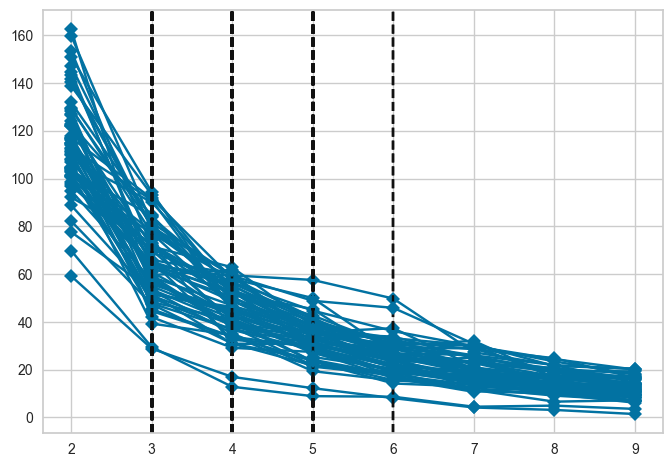

In [122]:
model_c = 'K-Medoids++'
data_ext = clustering_sent(model_c, data)

In [31]:
import numpy as np

def cosine(u, v):
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [32]:
def content_relevance(centroid,hypothesis_embeddings):
  d = {}
  for sentence,embed in hypothesis_embeddings.items():
    d[sentence] = cosine(centroid,embed)

  return d

In [33]:
def sentence_novelty(content_relevance_score,hypothesis_embeddings):
  novel_sentences = {}
  TAU = 0.95
  for sent1,embed1 in hypothesis_embeddings.items():
    max_similarity = 0
    for sent2,embed2 in hypothesis_embeddings.items():
      if sent1!=sent2 and cosine(embed1,embed2)>max_similarity:
          max_similarity = cosine(embed1,embed2)

    if max_similarity<TAU:
      novel_sentences[sent1] = 1

    elif max_similarity>TAU:
      if content_relevance_score[sent1]>content_relevance_score[sent2]:
        novel_sentences[sent1] = 1
      else:
        novel_sentences[sent1] = 1-max_similarity

  return novel_sentences

In [34]:
import math

def sentence_position(hypothesis):
  score_sent = {}
  for i,sent in enumerate(hypothesis):
      score_sent[sent] = max(0.5,math.exp(-(i+1)/(len(hypothesis)**(1/3))))

  return score_sent

In [35]:
import yake

def keyword_extractor(text):
    kword = []
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(text)

    for kw in range(len(keywords)):
        kword.append(keywords[kw])

    keywords = sorted(kword,key=lambda x:(-x[1],x[0]))

    return keywords

In [69]:
data_key = {}
for i in range(len(data)):
  tmp_dk = []
  tmp_dk = keyword_extractor(' '.join(data[i]))
  data_key[i] = tmp_dk

In [70]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sentiment = SentimentIntensityAnalyzer()
def vader_sentiment_scores(text):
  score = vader_sentiment.polarity_scores(text)
  return score['compound']

def prediksiSentiment(kalimat, keyword):
    wordlist = len(word_tokenize(kalimat))
    val = abs(vader_sentiment_scores(kalimat)/wordlist)

    nk = []
    for k in range(len(keyword)):
      if keyword[k][0] in kalimat:
        nk.append(keyword[k][1])


    return val, np.sum(nk)

In [40]:
def normalization_sen(text, keyword):
  lprob = []
  for i,sent in enumerate(text):
    val, key = prediksiSentiment(sent, keyword)
    prob = key + val
    lprob.append(prob)

  score_sent = {}
  for i,sent in enumerate(text):
    score_sent[sent] = lprob[i]

  return score_sent

In [115]:
len(rjumlahKata), len(rjumlahKalimat)

(180, 180)

In [220]:
print(np.min(rjumlahKata)), print(np.mean(rjumlahKalimat))

135
5.988888888888889


(None, None)

CLUS + SENTIMENT + KEYWORD + POSITION

In [123]:
def summary2(text):
    extractive = []
    for dc,v in text.items():
        tmp_ext = []
        val_cls = [v for v in text[dc][0].values()]
        key_cls = [k for k in text[dc][0].keys()]
        for vc in range(len(val_cls)):
          if len(tmp_ext) < 5:
            tmp_ext.append(key_cls[vc])

        extractive.append('\n'.join(tmp_ext))
    return extractive

In [124]:
import rouge
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=True,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

CLUSTERING + RKiPS (Relevansi, Keterbaruan informasi, Posisi, Sentiment-keyword)

In [127]:
def total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, sentiment, sentence_pos):
  final_score = {}
  for sent in content_relevance_score:
    final_score[sent] = (alpha*content_relevance_score[sent])+(beta*sentence_novelty_score[sent])+(gamma*sentence_pos[sent])+(teta*sentiment[sent])
  final_score = {k: v for k, v in sorted(final_score.items(), key=lambda item: item[1],reverse=True)}
      
  return final_score

def convert_to_embeddings(alpha, beta, gamma, teta, text_sentences, text_embeddings, keyword, sentence_pos):
  hypothesis_embeddings = {}
  sum = 0
  index = 0

  for sent in text_sentences:
    var = text_embeddings[index]
    sum += var
    hypothesis_embeddings[sent] = var
    index += 1

  centroid = sum/len(text_sentences)
  
  content_relevance_score = content_relevance(centroid,hypothesis_embeddings)
  sentence_novelty_score = sentence_novelty(content_relevance_score,hypothesis_embeddings)
  phrasa_score = normalization_sen(text_sentences, keyword)
  # position_score = sentence_position(text_sentences)
  return total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, phrasa_score, sentence_pos)

def iter_ext(data, data_pos, alpha, beta, gamma, teta):
    extractive = []
    index = 0
    
    result_dict = defaultdict(list)

    model = BertModel.from_pretrained('bert-base-uncased')

    for index in tqdm(range (len(data))):
        total = 0
        after_clus = []

        datapoint_length = {x:data[index]['cluster'].count(x) for x in data[index]['cluster']}
        sentence_pos = sentence_position(data_pos[index])
        for c in range(len(datapoint_length)):
            txt = []

            for t in range (len(data[index]['text'])):
                if data[index]['cluster'][t] == c:
                    txt.append(data[index]['text'][t])
        
            if len(txt) > 3:
               after_clus.extend(txt)
               
        embedding = np.empty((len(after_clus), model.config.hidden_size))

        for e in range (len(after_clus)):
          embedding[e,:] = sentence_emb(after_clus[e], model)

        predicted_summary = convert_to_embeddings(alpha, beta, gamma, teta, after_clus, embedding, data_key[index], sentence_pos) 
        result_dict[index].append(predicted_summary)

    return result_dict

In [128]:
extract_skp = iter_ext(data_ext, data, 0.5, 0.2, 0.2, 0.1)
raw_ext1 = summary2(extract_skp)
score = evaluator.get_scores(raw_ext_noclus, doc_abs)
score

100%|██████████| 60/60 [00:52<00:00,  1.14it/s]


{'rouge-3': {'f': 0.017691922445875294,
  'p': 0.014263079967941102,
  'r': 0.024035090881892016},
 'rouge-4': {'f': 0.006124702515843469,
  'p': 0.0049207808613759155,
  'r': 0.008365524294455456},
 'rouge-1': {'f': 0.32100854662007766,
  'p': 0.2575088860532361,
  'r': 0.4363845866789824},
 'rouge-2': {'f': 0.061393010973688274,
  'p': 0.04928970975867242,
  'r': 0.08356464569293079},
 'rouge-l': {'f': 0.34675305096411013,
  'p': 0.28673393196339547,
  'r': 0.4456101600200522}}

In [120]:
extract_skp = iter_ext(data_ext, data, 0.5, 0.2, 0.2, 0.1)
raw_ext1 = summary2(extract_skp)
score = evaluator.get_scores(raw_ext_noclus, doc_abs)
score

100%|██████████| 60/60 [01:00<00:00,  1.01s/it]


{'rouge-3': {'f': 0.017691922445875294,
  'p': 0.014263079967941102,
  'r': 0.024035090881892016},
 'rouge-4': {'f': 0.006124702515843469,
  'p': 0.0049207808613759155,
  'r': 0.008365524294455456},
 'rouge-1': {'f': 0.32100854662007766,
  'p': 0.2575088860532361,
  'r': 0.4363845866789824},
 'rouge-2': {'f': 0.061393010973688274,
  'p': 0.04928970975867242,
  'r': 0.08356464569293079},
 'rouge-l': {'f': 0.34675305096411013,
  'p': 0.28673393196339547,
  'r': 0.4456101600200522}}

In [90]:
# extract_skp = iter_ext(data_ext, data, 0.5, 0.2, 0.2, 0.1)
raw_ext1 = summary2(extract_skp)
score = evaluator.get_scores(raw_ext_noclus, doc_abs)
score

{'rouge-3': {'f': 0.017691922445875294,
  'p': 0.014263079967941102,
  'r': 0.024035090881892016},
 'rouge-4': {'f': 0.006124702515843469,
  'p': 0.0049207808613759155,
  'r': 0.008365524294455456},
 'rouge-1': {'f': 0.32100854662007766,
  'p': 0.2575088860532361,
  'r': 0.4363845866789824},
 'rouge-2': {'f': 0.061393010973688274,
  'p': 0.04928970975867242,
  'r': 0.08356464569293079},
 'rouge-l': {'f': 0.34675305096411013,
  'p': 0.28673393196339547,
  'r': 0.4456101600200522}}

In [269]:
# from tqdm import tqdm
# from collections import defaultdict
# def total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, sentiment, sentence_pos):
#   final_score = {}
#   for sent in content_relevance_score:
#     final_score[sent] = (alpha*content_relevance_score[sent])+(beta*sentence_novelty_score[sent])+(gamma*sentence_pos[sent])+(teta*sentiment[sent])
#   final_score = {k: v for k, v in sorted(final_score.items(), key=lambda item: item[1],reverse=True)}
      
#   return final_score

# def convert_to_embeddings(alpha, beta, gamma, teta, text_sentences, text_embeddings, keyword, sentence_pos):
#   hypothesis_embeddings = {}
#   sum = 0
#   index = 0

#   for sent in text_sentences:
#     var = text_embeddings[index]
#     sum += var
#     hypothesis_embeddings[sent] = var
#     index += 1

#   centroid = sum/len(text_sentences)
  
#   content_relevance_score = content_relevance(centroid,hypothesis_embeddings)
#   sentence_novelty_score = sentence_novelty(content_relevance_score,hypothesis_embeddings)
#   phrasa_score = normalization_sen(text_sentences, keyword)
#   # position_score = sentence_position(text_sentences)
#   return total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, phrasa_score, sentence_pos)

# def iter_ext(data, data_pos, alpha, beta, gamma, teta):
#     extractive = []
#     index = 0
    
#     result_dict = defaultdict(list)

#     model = BertModel.from_pretrained('bert-base-uncased')

#     for index in tqdm(range (len(data))):
#         total = 0
#         after_clus = []

#         datapoint_length = {x:data[index]['cluster'].count(x) for x in data[index]['cluster']}
#         sentence_pos = sentence_position(data_pos[index])
#         for c in range(len(datapoint_length)):
#             txt = []

#             for t in range (len(data[index]['text'])):
#                 if data[index]['cluster'][t] == c:
#                     txt.append(data[index]['text'][t])
        
#             if len(txt) > 2:
#                after_clus.extend(txt)
               
#         embedding = np.empty((len(after_clus), model.config.hidden_size))

#         for e in range (len(after_clus)):
#           embedding[e,:] = sentence_emb(after_clus[e], model)

#         predicted_summary = convert_to_embeddings(alpha, beta, gamma, teta, after_clus, embedding, data_key[index], sentence_pos) 
#         result_dict[index].append(predicted_summary)

#     return result_dict

# # extract_skp = iter_ext(data_ext, data, 0.6, 0.2, 0.1, 0.1)
# params = {'alpha': [0.8, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3],
#          'beta': [0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.4, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.3, 0.3],
#          'gamma': [0.05, 0.1, 0.05, 0.15, 0.05, 0.15, 0.10, 0.20, 0.10, 0.15, 0.05, 0.05, 0.05, 0.05, 0.15, 0.15, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2],
#          'teta': [0.05, 0.1, 0.15, 0.05, 0.05, 0.15, 0.20, 0.10, 0.10, 0.05, 0.15, 0.05, 0.05, 0.15, 0.05, 0.15, 0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0.2],}
# scores = []
# for i in tqdm(range(len(params['alpha']))):
#    extract_skp = iter_ext(data_ext, data, params['alpha'][i], params['beta'][i], params['gamma'][i], params['teta'][i])
#    raw_ext1 = summary2(extract_skp)
#    scores.append(evaluator.get_scores(raw_ext1, doc_abs))

100%|██████████| 23/23 [24:48<00:00, 64.72s/it]


Position

In [55]:
def total_score(alpha, beta, gamma, content_relevance_score, sentence_novelty_score, position_score):
  final_score = {}
  for sent in content_relevance_score:
    final_score[sent] = alpha*content_relevance_score[sent]+beta*sentence_novelty_score[sent]+gamma*position_score[sent]
  final_score = {k: v for k, v in sorted(final_score.items(), key=lambda item: item[1],reverse=True)}

  return final_score

def convert_to_embeddings(alpha, beta, gamma, text_sentences, text_embeddings, text_position):
  hypothesis_embeddings = {}
  sum = 0
  index = 0

  for sent in text_sentences:
    var = text_embeddings[index]
    sum += var
    hypothesis_embeddings[sent] = var
    index += 1

  centroid = sum/len(text_sentences)

  content_relevance_score = content_relevance(centroid,hypothesis_embeddings)
  sentence_novelty_score = sentence_novelty(content_relevance_score,hypothesis_embeddings)
  position_score = sentence_position(text_position)
  return total_score(alpha, beta, gamma, content_relevance_score, sentence_novelty_score, position_score)

from collections import defaultdict
def iter_ext(data):
    extractive = []
    index = 0

    result_dict = defaultdict(list)

    for i in tqdm(range(len(data))):
        total = 0
        print('data ke ' + str(i))
        model = BertModel.from_pretrained('bert-base-uncased')

        # embedding = np.empty((len(data[i]), 768))
        embedding = np.empty((len(data[i]), model.config.hidden_size))

        for e in range (len(data[i])):
          embedding[e,:] = sentence_emb(data[i][e], model)
          # embedding[e,:] = sbert_model.encode(data[i][e])[0]

        # print(len(txt))
        predicted_summary = convert_to_embeddings(0.6, 0.2, 0.2, data[i], embedding, data[i])

        result_dict[i].append(predicted_summary)

    return result_dict

extract_p = iter_ext(data)

  0%|          | 0/60 [00:00<?, ?it/s]

data ke 0


  2%|▏         | 1/60 [00:08<08:30,  8.66s/it]

data ke 1


  3%|▎         | 2/60 [00:17<08:24,  8.69s/it]

data ke 2


  5%|▌         | 3/60 [00:26<08:14,  8.67s/it]

data ke 3


  7%|▋         | 4/60 [00:34<08:09,  8.74s/it]

data ke 4


  8%|▊         | 5/60 [00:43<08:00,  8.74s/it]

data ke 5


 10%|█         | 6/60 [00:52<07:46,  8.63s/it]

data ke 6


 12%|█▏        | 7/60 [01:00<07:35,  8.59s/it]

data ke 7


 13%|█▎        | 8/60 [01:09<07:30,  8.66s/it]

data ke 8


 15%|█▌        | 9/60 [01:18<07:22,  8.68s/it]

data ke 9


 17%|█▋        | 10/60 [01:27<07:18,  8.78s/it]

data ke 10


 18%|█▊        | 11/60 [01:36<07:12,  8.84s/it]

data ke 11


 20%|██        | 12/60 [01:44<07:00,  8.77s/it]

data ke 12


 22%|██▏       | 13/60 [01:53<06:48,  8.70s/it]

data ke 13


 23%|██▎       | 14/60 [02:02<06:45,  8.81s/it]

data ke 14


 25%|██▌       | 15/60 [02:11<06:39,  8.87s/it]

data ke 15


 27%|██▋       | 16/60 [02:20<06:32,  8.93s/it]

data ke 16


 28%|██▊       | 17/60 [02:29<06:22,  8.89s/it]

data ke 17


 30%|███       | 18/60 [02:38<06:14,  8.91s/it]

data ke 18


 32%|███▏      | 19/60 [02:46<06:02,  8.85s/it]

data ke 19


 33%|███▎      | 20/60 [02:55<05:54,  8.87s/it]

data ke 20


 35%|███▌      | 21/60 [03:04<05:47,  8.91s/it]

data ke 21


 37%|███▋      | 22/60 [03:13<05:39,  8.94s/it]

data ke 22


 38%|███▊      | 23/60 [03:21<05:20,  8.66s/it]

data ke 23


 40%|████      | 24/60 [03:30<05:15,  8.78s/it]

data ke 24


 42%|████▏     | 25/60 [03:39<05:11,  8.89s/it]

data ke 25


 43%|████▎     | 26/60 [03:48<05:02,  8.89s/it]

data ke 26


 45%|████▌     | 27/60 [03:57<04:52,  8.87s/it]

data ke 27


 47%|████▋     | 28/60 [04:06<04:47,  8.99s/it]

data ke 28


 48%|████▊     | 29/60 [04:16<04:40,  9.04s/it]

data ke 29


 50%|█████     | 30/60 [04:25<04:31,  9.05s/it]

data ke 30


 52%|█████▏    | 31/60 [04:34<04:20,  8.98s/it]

data ke 31


 53%|█████▎    | 32/60 [04:42<04:10,  8.96s/it]

data ke 32


 55%|█████▌    | 33/60 [04:51<03:59,  8.85s/it]

data ke 33


 57%|█████▋    | 34/60 [05:00<03:50,  8.86s/it]

data ke 34


 58%|█████▊    | 35/60 [05:09<03:40,  8.81s/it]

data ke 35


 60%|██████    | 36/60 [05:18<03:32,  8.84s/it]

data ke 36


 62%|██████▏   | 37/60 [05:26<03:23,  8.84s/it]

data ke 37


 63%|██████▎   | 38/60 [05:35<03:15,  8.89s/it]

data ke 38


 65%|██████▌   | 39/60 [05:44<03:05,  8.85s/it]

data ke 39


 67%|██████▋   | 40/60 [05:53<02:56,  8.84s/it]

data ke 40


 68%|██████▊   | 41/60 [06:02<02:48,  8.86s/it]

data ke 41


 70%|███████   | 42/60 [06:11<02:38,  8.83s/it]

data ke 42


 72%|███████▏  | 43/60 [06:19<02:28,  8.72s/it]

data ke 43


 73%|███████▎  | 44/60 [06:28<02:20,  8.79s/it]

data ke 44


 75%|███████▌  | 45/60 [06:37<02:11,  8.80s/it]

data ke 45


 77%|███████▋  | 46/60 [06:45<02:01,  8.70s/it]

data ke 46


 78%|███████▊  | 47/60 [06:54<01:53,  8.74s/it]

data ke 47


 80%|████████  | 48/60 [07:03<01:46,  8.84s/it]

data ke 48


 82%|████████▏ | 49/60 [07:12<01:37,  8.85s/it]

data ke 49


 83%|████████▎ | 50/60 [07:21<01:28,  8.84s/it]

data ke 50


 85%|████████▌ | 51/60 [07:29<01:18,  8.70s/it]

data ke 51


 87%|████████▋ | 52/60 [07:38<01:09,  8.72s/it]

data ke 52


 88%|████████▊ | 53/60 [07:47<01:01,  8.77s/it]

data ke 53


 90%|█████████ | 54/60 [07:56<00:52,  8.80s/it]

data ke 54


 92%|█████████▏| 55/60 [08:05<00:44,  8.85s/it]

data ke 55


 93%|█████████▎| 56/60 [08:13<00:35,  8.79s/it]

data ke 56


 95%|█████████▌| 57/60 [08:22<00:26,  8.84s/it]

data ke 57


 97%|█████████▋| 58/60 [08:31<00:17,  8.68s/it]

data ke 58


 98%|█████████▊| 59/60 [08:39<00:08,  8.67s/it]

data ke 59


100%|██████████| 60/60 [08:48<00:00,  8.81s/it]


In [118]:
raw_ext2 = summary2(extract_p)
scores2 = evaluator.get_scores(raw_ext2, doc_abs)
scores2

{'rouge-3': {'f': 0.016143753053154814,
  'p': 0.0127863364086384,
  'r': 0.02244492547971052},
 'rouge-4': {'f': 0.005134065422722776,
  'p': 0.004031606042596256,
  'r': 0.007248199572340892},
 'rouge-1': {'f': 0.31898226378435274,
  'p': 0.25556214985222037,
  'r': 0.43391495776981565},
 'rouge-2': {'f': 0.05883690191187126,
  'p': 0.046843098247926464,
  'r': 0.080880126323702},
 'rouge-l': {'f': 0.3469916819960017,
  'p': 0.28654754507059227,
  'r': 0.446387731656577}}

In [99]:
import bert_score
from bert_score import score

eP, eR, eF1 = score(raw_ext1, doc_abs, model_type="bert-base-uncased", num_layers=9)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [100]:
eF1.mean()

tensor(0.5802)

In [101]:
eP, eR, eF1 = score(raw_ext2, doc_abs_one, model_type="bert-base-uncased", num_layers=9)
eF1.mean()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor(0.5491)